Authors: Rui , Matt , Louis. 
This is intented to run in online google colab. There are sections that make it easier to navigate. The dataset is downloaded from https://www.kaggle.com/shayanfazeli/heartbeat and uploaded to google colab as 'heartbeat.zip'. In order to run each model with different datasets, you will need to change the X_input variables before training each model. In order to recreate the training process use seed(1). Datasets need to prepared before training and this may involve a non-linear running of the colab code snippets for some cases in transfer-learning and NR+IN runs.

In [ ]:
!unzip 'heartbeat.zip'

Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


In [ ]:
%tensorflow_version 1.x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load in csv mitbih

In [ ]:
#last element is the class
#show the balance of dataset
#Load in raw data
import csv
y = np.array([])
X = list([])
i = 0
with open('mitbih_train.csv', newline='') as f:
  reader = csv.reader(f)
  for row in reader:
    if(i%1 == 0):
      row = np.array(row, dtype=np.float32)
      X.append(row[:-1])
      y = np.append(y, int(row[-1]))
    i += 1
    print(i)
  f.close()
with open('mitbih_test.csv', newline='') as f:
  reader = csv.reader(f)
  for row in reader:
    if(i%1 == 0):
      row = np.array(row, dtype=np.float32)
      X.append(row[:-1])
      y = np.append(y, int(row[-1]))
    i += 1
    print(i)
  f.close()
print(np.unique(y, return_counts=True))

Streaming output truncated to the last 5000 lines.
104448
104449
104450
104451
104452
104453
104454
104455
104456
104457
104458
104459
104460
104461
104462
104463
104464
104465
104466
104467
104468
104469
104470
104471
104472
104473
104474
104475
104476
104477
104478
104479
104480
104481
104482
104483
104484
104485
104486
104487
104488
104489
104490
104491
104492
104493
104494
104495
104496
104497
104498
104499
104500
104501
104502
104503
104504
104505
104506
104507
104508
104509
104510
104511
104512
104513
104514
104515
104516
104517
104518
104519
104520
104521
104522
104523
104524
104525
104526
104527
104528
104529
104530
104531
104532
104533
104534
104535
104536
104537
104538
104539
104540
104541
104542
104543
104544
104545
104546
104547
104548
104549
104550
104551
104552
104553
104554
104555
104556
104557
104558
104559
104560
104561
104562
104563
104564
104565
104566
104567
104568
104569
104570
104571
104572
104573
104574
104575
104576
104577
104578
104579
104580
104581
104582
1045

# Noise Reduction

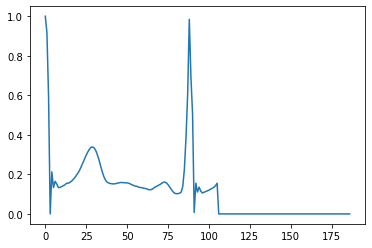

NameError: ignored

In [ ]:
#Noise Reduction

#Take a moving average is 3
#problem with average reduces extremes, put in place a threshold
#dont want the model to focus on small changes
#testing 0-3
def reduce_noise(arr):
  x_ma = moving_average(arr)
  for i in range(3):
    s = 50 * i
    e = 50 * i + 50
    maxes = np.where(arr == max(arr[s:e]))
    mins = np.where(arr == min(arr[s:e]))
    x_ma[maxes] = max(arr[s:e])
    x_ma[mins] = min(arr[s:e])
  return x_ma
def moving_average(a, n=2):
    res = np.copy(a)
    for i in range(n,len(a)-n):
      res[i] = np.average(a[i-n:i+n])
    return res
i = 8758
plt.plot(reduce_noise(X[i]))
plt.show()
plt.plot(X_bc[i])
plt.show()
print(np.unique(y, return_counts=True))

In [ ]:
X_nr = list([])
i = 0
for x in X_bc:
  x_nr = reduce_noise(x)
  X_nr.append(x_nr)
  i += 1
  print(i)

# Interpolation

In [ ]:
#Interpolate Data to Normalize dataset
#the data orginal consists of the time sequences but no all of the same length
#the solution stretch out the data to a constant length and use interpolation to fill in the missing data
#to find out if the length of the time sequence was significant or not
from scipy import interpolate as spinterpolate
def interpolate(arr):
  zeros = arr[-3:]
  for i in range(2, len(arr)-2):
    if np.array_equal(arr[i:i+3], zeros):
      stretch_ratio = len(arr)/i
      x_stretch = (np.arange(i) * stretch_ratio).astype(int)
      x_missing = np.setdiff1d(np.arange(len(arr)), x_stretch)
      f = spinterpolate.interp1d(x_stretch, arr[0:i],kind='nearest',fill_value="extrapolate")
      y_missing = f(x_missing)
      res = np.zeros(len(arr))
      for i in np.arange(len(arr)-1):
        if(x_missing[x_missing == i]):
          res[i] = y_missing[np.where(x_missing == i)]
        if(x_stretch[x_stretch == i]):
          res[i] = arr[int(i / stretch_ratio)]
      return res
plt.plot(X[33])
plt.show()
plt.plot(interpolate(X[33]))
plt.show()


In [ ]:
X_itpl = list([])
i = 0
for x in X_nr:
  x_itpl = interpolate(x)
  X_itpl.append(x_itpl)
  i += 1
  print(i)

# sampling and input selection

In [ ]:
#Choose dataset to use
##shuffle dataset
##training test split
import random
X_input = X
y_input = y
c = list(zip(X_input, y_input))
random.shuffle(c)
(Xs, ys) = zip(*c)
Xs = np.array(Xs)
ys = np.array(ys)
##Split Datasets
split = int(len(X_input) * 0.8)
X_train = Xs[:split]
y_train = ys[:split]
X_test = Xs[split:]
y_test = ys[split:]

In [ ]:
#Theres two many of class 0 which lead to overfitting in train
#Oversampled other classes using naive oversampling
#Resample the Dataset to evenly distribute classes
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler({1: 20000, 2: 20000, 3: 20000, 4: 20000})
print(np.unique(y_train, return_counts='true'))
X_train, y_train = ros.fit_resample(X_train, y_train)
print(np.unique(y_train, return_counts='true'))

In [ ]:
#Under sample test set
#undersample for equal split in validation
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler({0: 2500})
print(np.unique(y_test, return_counts='true'))
X_test, y_test = ros.fit_resample(X_test, y_test)
print(np.unique(y_test, return_counts='true'))

# 1DCNN

In [ ]:
import keras.utils as util
from keras.layers import LeakyReLU
np.random.seed(1)
#1D CNN Approach(raw/raw-resampled/interpolation/interpolation-resampled)
#--transfer learning between datasets
#--transformer network
#--agreement between ground truth vs accuracy
#--schedule data for each epoch
#--does length describe ecg in anyway
X_train_rs = np.reshape(X_train, (*X_train.shape, 1))
X_test_rs = np.reshape(X_test, (*X_test.shape, 1))
y_train_oh = util.to_categorical(y_train)
y_test_oh = util.to_categorical(y_test)
y_oh = util.to_categorical(y)
print(y_train)
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Reshape
	
model_mc = Sequential()
model_mc.add(Reshape((187,1),input_shape=(187,)))
model_mc.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_mc.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_mc.add(Dropout(0.5))
model_mc.add(MaxPooling1D(pool_size=6))
model_mc.add(Flatten())
model_mc.add(Dense(100, activation='relu'))
model_mc.add(Dense(5, activation='softmax'))

from keras.optimizers import rmsprop

model_mc.compile(loss='categorical_crossentropy', optimizer=rmsprop(lr=0.0001), metrics=['accuracy'])

history = model_mc.fit(X_train, y_train_oh,
              batch_size=128,
              epochs=10,
              validation_data=(X_test, y_test_oh),
              shuffle=True, )

# Binary Classifier

In [ ]:
#add binary dataset to current dataset
#set all non 0 values to 1
import random
y_bc = np.where(y < 1, y, 1)
X_bc = X
i = 0
with open('ptbdb_abnormal.csv', newline='') as h:
  reader = csv.reader(h)
  for row in reader:
    if(i%1 == 0):
      row = np.array(row, dtype=np.float32)
      X_bc.append(row[:-1])
      y_bc = np.append(y_bc, int(row[-1]))
    i += 1
    print(i)
  h.close()
with open('ptbdb_normal.csv', newline='') as h:
  reader = csv.reader(h)
  for row in reader:
    if(i%1 == 0):
      row = np.array(row, dtype=np.float32)
      X_bc.append(row[:-1])
      y_bc = np.append(y_bc, int(row[-1]))
    i += 1
    print(i)
  h.close()
print(np.unique(y_bc, return_counts=True))

In [ ]:
import random
X_input = X_itpl
y_input = y_bc
c = list(zip(X_input, y_input))
random.shuffle(c)
(Xs, ys) = zip(*c)
Xs = np.array(Xs)
ys = np.array(ys)
##Split Datasets
split = int(len(X_input) * 0.8)
X_train = Xs[:split]
y_train = ys[:split]
X_test = Xs[split:]
y_test = ys[split:]
print(np.unique(y_test, return_counts=True))

In [ ]:
#Resample the Dataset to evenly distribute classes[choose X_itpl or X]
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler({1: 50000})
print(np.unique(y_train, return_counts='true'))
X_train, y_train = ros.fit_resample(X_train, y_train)
print(np.unique(y_train, return_counts='true'))

In [ ]:
#Under sample test set
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler({0: 5000})
print(np.unique(y_test, return_counts='true'))
X_test, y_test = ros.fit_resample(X_test, y_test)
print(np.unique(y_test, return_counts='true'))

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Reshape
	
model_bc = Sequential()
model_bc.add(Reshape((187,1),input_shape=(187,)))
model_bc.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_bc.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_bc.add(Dropout(0.5))
model_bc.add(MaxPooling1D(pool_size=6))
model_bc.add(Flatten())
model_bc.add(Dense(100, activation='relu'))
model_bc.add(Dense(1, activation='sigmoid'))

from keras.optimizers import rmsprop

model_bc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_bc.fit(X_train, y_train,
              batch_size=128,
              epochs=10,
              validation_data=(X_test, y_test),
              shuffle=True, )

# Transfer Learning

In [ ]:
#binary to multiclass and vice versa
from keras import Model
model_tl = model_bc
x = model_tl.get_layer(model_tl.layers[3].name).output
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=6)(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(5, activation='softmax')(x)
model_tl = Model(model_tl.input, x)

In [ ]:
model_bc.summary()
model_tl.summary()
model_mc.summary()

In [ ]:
#Load in binary set for transfer learning
import csv
y_tl = np.array([])
X_tl = list([])
i = 0
with open('ptbdb_abnormal.csv', newline='') as h:
  reader = csv.reader(h)
  for row in reader:
    if(i%1 == 0):
      row = np.array(row, dtype=np.float32)
      X_tl.append(row[:-1])
      y_tl = np.append(y_tl, int(row[-1]))
    i += 1
    print(i)
  h.close()
with open('ptbdb_normal.csv', newline='') as h:
  reader = csv.reader(h)
  for row in reader:
    if(i%1 == 0):
      row = np.array(row, dtype=np.float32)
      X_tl.append(row[:-1])
      y_tl = np.append(y_tl, int(row[-1]))
    i += 1
    print(i)
  h.close()
print(np.unique(y_test, return_counts=True))

In [ ]:
#Choose dataset to use
##shuffle dataset
import random
import keras.utils as util
X_input_tl = X_itpl
y_input_tl = util.to_categorical(y)
c = list(zip(X_input_tl, y_input_tl))
random.shuffle(c)
(Xs_tl, ys_tl) = zip(*c)
Xs_tl = np.array(Xs_tl)
ys_tl = np.array(ys_tl)
##Split Datasets
split = int(len(X_input_tl) * 0.8)
X_train_tl = Xs_tl[:split]
y_train_tl = ys_tl[:split]
X_test_tl = Xs_tl[split:]
y_test_tl = ys_tl[split:]

In [ ]:
#model_tl.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_tl.compile(loss='categorical_crossentropy', optimizer=rmsprop(lr=0.0001), metrics=['accuracy'])
history = model_tl.fit(X_train, y_train_oh,
              batch_size=128,
              epochs=10,
              validation_data=(X_test, y_test_oh),
              shuffle=True, )